In [1]:
import sklearn.preprocessing as pre, scipy, numpy as np, matplotlib.pyplot as plt, glob, sys, os
import pandas as pd, seaborn as sns, argparse, pyemma as py, pickle, copy
import mdtraj as md
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

from hde import HDE, analysis

sys.path.insert(1, '../msms/')
from utils import * 

Using TensorFlow backend.


In [4]:
## load -15 K starting distribution (equivalent to T-jump)
## Use biased data, reweighting each trajectory

midway3_path = './Tm-15_trajs/'
lag = 1
pstride = 100

seq_list = ['CGCATATATAT', 'CCTATATATCC', 'TATAGCGATAT', 'TTTTTTTTTTT']
wc_idxs = np.array([10,19,28,37,47,57,67,77])

# if initial distribution has not been generated
generate_initial = False

# histogram distances based on biased free energy maps

def load_colvar_bias(colvar, temp):
    '''read colvar file and return metad bias for each frame'''
    
    # make dataframes with consisten columns for each colvar
    kB = 8.3124 / 1000
    df = pd.read_csv(colvar, header=0, delim_whitespace=True)
        
    # convert bias into thermodynamics weighting
    bias = np.array(df)[:,-3] #1:-2
    weights = np.exp(bias/(kB*temp)) 
    return weights

if generate_initial:
    for seq in seq_list:
        save_name = f'./save_outputs/{seq}_lag-{lag}_dict'
        save_dict = pickle.load(open(save_name, 'rb'))
        fig, axes = plt.subplots(4, 2, figsize=(6, 12))

        # load data from equilibrium MSM
        base_idxs = [0, 2, 4, 6]
        base_list = save_dict['base_list'] 
        all_dists = save_dict['all_dists']
        srv_indv_list = save_dict['srv_indv_list']
        SRV_list = save_dict['SRV_list']
        cluster_list = save_dict['cluster_list']

        # set up initial distribution for relaxation simlulation
        p0_metad_list = []

        for bidx, base, cluster, org_basis, SRV, equ_dists, ax_row in \
            zip(base_idxs, base_list, cluster_list, srv_indv_list, SRV_list, all_dists, axes):

            # load low temp data
            npy_name = glob.glob(f'./Tm-15_trajs/{seq}_base-{bidx}*/dist*')[0]
            colvar_name = glob.glob(f'./Tm-15_trajs/{seq}_base-{bidx}*/COLVAR')[0]
            temp = int(npy_name.split('temp-')[-1][:3])
            weights = load_colvar_bias(colvar_name, temp)[::2] # saved twice as frequently
            dists = np.load(npy_name)

            common_idxs = translate_pairs(11, base)
            print(base, weights.shape, dists[:, common_idxs].shape, np.mean(dists[:, common_idxs]))
            print(base, equ_dists[:, :, common_idxs].shape, np.mean(equ_dists[:, : , common_idxs]))

            # translate into SRV and TICA basis and assign cluster
            srv_metad_basis = SRV.transform(1/dists)
            dtraj_metad = cluster.assign(srv_metad_basis)

            # double check SRV assignment for SRV equ distances
            basis = [SRV.transform(1/d) for d in equ_dists]

            # set initial probability dist for relaxation experiment
            nclusters = len(cluster.clustercenters)
            p0_arr = []
            for i in range(nclusters):
                cluster_idxs = np.where(dtraj_metad==i)[0]
                p0 = np.sum(weights[cluster_idxs])
                p0_arr.append(p0)
            p0_arr = np.array(p0_arr)/np.sum(p0_arr)
            p0_metad_list.append(p0_arr)
            print(p0_arr)

            # plot Tm SRV distribution compared to low T
            srv_plot_tm = np.concatenate(basis)[::pstride]
            srv_plot_metad = srv_metad_basis[::pstride//10]
            ax_row[0].scatter(srv_plot_tm[:, 0], srv_plot_tm[:, 1])
            ax_row[1].scatter(srv_plot_metad[:, 0], srv_plot_metad[:, 1], c=weights[::pstride//10])

        # update and saved dict
        save_dict['p0_metad_list'] = p0_metad_list
        save_dict = pickle.dump(save_dict, open(save_name, 'wb'))

        axes[0, 0].set_title('SRV Tm')
        axes[0, 1].set_title('SRV Tm-15 (biased)')

def score_all_cont(msm, base, dtraj, base_dists, AT_cutoff=0.7, GC_cutoff=0.65):
    '''assign A:T and G:C scores by summing all available contacts below respective cutoffs'''
    
    # find possible AT and GC pairs
    AT_possible, GC_possible = [], []
    base_dists = np.concatenate(base_dists)

    s1_bps = [t for t in seq]
    s2_bps = [complement_dict[t] for t in reversed(seq)]
    if base != 'control':
        del s1_bps[int(base.replace('b', ''))-1]

    idx = 0
    for b1 in s1_bps:
        for b2 in s2_bps:
            if b1+b2 in ['AT', 'TA']:
                AT_possible.append(idx)
            elif b1+b2 in ['GC', 'CG']:
                GC_possible.append(idx)
            idx+=1
            
    print('AT len: ', len(AT_possible), 'GC len: ', len(GC_possible))

    # assign AT and GC scores
    AT_scores, GC_scores = [], []

    for i in range(msm.nstates):
        micro_idxs = np.where(dtraj==i)
        all_avgs = np.mean(base_dists[micro_idxs], axis=0)
        AT_avgs, GC_avgs = all_avgs[AT_possible], all_avgs[GC_possible]
        AT_score, GC_score = np.sum(AT_avgs<AT_cutoff), np.sum(GC_avgs<GC_cutoff)
        AT_scores.append(AT_score)
        GC_scores.append(GC_score)
        
    return AT_scores, GC_scores


def score_by_bp(msm, dtraj, dists, base, AT_cutoff=0.7, GC_cutoff=0.65):
    '''assign A:T and G:C scores by considering available binding sites one bp at a time
       will never allow more than 11 or 10 contacts for intact, abasic respectively'''
    
    # find possible AT and GC pairs
    complement_dict = {'A':'T', 'T':'A', 'G':'C', 'C':'G'}
    dists = np.concatenate(dists)

    s1_bps = [t for t in seq]
    s2_bps = [complement_dict[t] for t in reversed(seq)]
    if base != 'control':
        del s1_bps[int(base.replace('b', ''))-1]

    idx = 0
    AT_sums, GC_sums = np.zeros(len(dists)), np.zeros(len(dists))
    for b1 in s1_bps:
        AT_possible, GC_possible = [], []
        for b2 in s2_bps:
            if b1+b2 in ['AT', 'TA']:
                AT_possible.append(idx)
            elif b1+b2 in ['GC', 'CG']:
                GC_possible.append(idx)
            idx+=1
                
        AT_sums += np.sum((dists[:, AT_possible] < AT_cutoff), axis=1) > 0
        GC_sums += np.sum((dists[:, GC_possible] < GC_cutoff), axis=1) > 0
    
    AT_scores, GC_scores = [], []
    for i in range(msm.nstates):
        micro_idxs = np.where(dtraj==i)
        AT_avgs, GC_avgs = np.mean(AT_sums[micro_idxs], axis=0), np.mean(GC_sums[micro_idxs], axis=0)
        AT_scores.append(AT_avgs)
        GC_scores.append(GC_avgs)
        
    return AT_scores, GC_scores


def score_native_cont(msm, base, dtraj, base_dists, AT_cutoff=0.7, GC_cutoff=0.65):
    '''assign continous score based on distance between all native wc contacts'''
        
    AT_wc, GC_wc = [], []
    base_dists = np.concatenate(base_dists)
    
    s1_bps = [t for t in seq]
    s2_bps = [complement_dict[t] for t in reversed(seq)]
    if base != 'control':
        del s1_bps[int(base.replace('b', ''))-1]

    s1_idx = list(np.arange(len(seq)))
    s2_idx = [i for i in reversed(s1_idx)]
    if base != 'control':
        del s1_idx[int(base.replace('b', ''))-1]
        
    idx = 0
    for b1, i1 in zip(s1_bps, s1_idx):
        for b2, i2 in zip(s2_bps, s2_idx):
            if i1==i2:
                if b1+b2 in ['AT', 'TA']:
                    AT_wc.append(idx)
                elif b1+b2 in ['GC', 'CG']:
                    GC_wc.append(idx)
            idx+=1
    
    print(AT_wc, GC_wc)
    print('AT len: ', len(AT_wc), 'GC len: ', len(GC_wc))
    
    # assign AT and GC scores
    AT_scores, GC_scores = [], []

    for i in range(msm.nstates):
        micro_idxs = np.where(dtraj==i)
        all_avgs = np.mean(base_dists[micro_idxs], axis=0)
        AT_avgs, GC_avgs = all_avgs[AT_wc], all_avgs[GC_wc]
        AT_score, GC_score = np.sum(AT_avgs<AT_cutoff), np.sum(GC_avgs<GC_cutoff)
        AT_scores.append(AT_score)
        GC_scores.append(GC_score)
        
    return AT_scores, GC_scores

def score_native_dist(msm, base, dtraj, base_dists, max_dist=1.0):
    '''assign continous score based on distance between all native wc contacts'''
    
    def score_dist(d):
        score = 2*(1-d)
        score[score < 0] = 0
        return score
        
    AT_wc, GC_wc = [], []
    base_dists = np.concatenate(base_dists)
    
    s1_bps = [t for t in seq]
    s2_bps = [complement_dict[t] for t in reversed(seq)]
    if base != 'control':
        del s1_bps[int(base.replace('b', ''))-1]

    s1_idx = list(np.arange(len(seq)))
    s2_idx = [i for i in reversed(s1_idx)]
    if base != 'control':
        del s1_idx[int(base.replace('b', ''))-1]
        
    idx = 0
    for b1, i1 in zip(s1_bps, s1_idx):
        for b2, i2 in zip(s2_bps, s2_idx):
            if i1==i2:
                if b1+b2 in ['AT', 'TA']:
                    AT_wc.append(idx)
                elif b1+b2 in ['GC', 'CG']:
                    GC_wc.append(idx)
            idx+=1
    
    print(AT_wc, GC_wc)
    print('AT len: ', len(AT_wc), 'GC len: ', len(GC_wc))
    
    # assign AT and GC scores
    AT_scores, GC_scores = [], []

    for i in range(msm.nstates):
        micro_idxs = np.where(dtraj==i)
        all_avgs = np.mean(base_dists[micro_idxs], axis=0)
        AT_avgs, GC_avgs = all_avgs[AT_wc], all_avgs[GC_wc]
        AT_score, GC_score = np.sum(score_dist(AT_avgs)), np.sum(score_dist(GC_avgs))
        AT_scores.append(AT_score)
        GC_scores.append(GC_score)
        
    return AT_scores, GC_scores


def exp_sum_fit(x, *argv):
    #def exp_sum_fit(x, a, b1, b2, b3)
    '''fit sum of exponentials to determine amplitudes'''

    t_list =  msm.timescales(nits)
    exp_sum = argv[0]*np.ones(len(times))
    for t, b in zip(t_list, argv[1:]):
        exp_sum += b*np.exp(-x/t)

    #exp_sum = a + b1*np.exp(-x/t1) + b2*np.exp(-x/t2) + b3*np.exp(-x/t3)
    return exp_sum

CGCATATATAT control
CGCATATATAT control
CGCATATATAT control
CGCATATATAT b2
CGCATATATAT b2
CGCATATATAT b2
CGCATATATAT b4
CGCATATATAT b4
CGCATATATAT b4
CGCATATATAT b6
CGCATATATAT b6
CGCATATATAT b6
TATAGCGATAT control
TATAGCGATAT control
TATAGCGATAT control
TATAGCGATAT b2
TATAGCGATAT b2
TATAGCGATAT b2
TATAGCGATAT b4
TATAGCGATAT b4
TATAGCGATAT b4
TATAGCGATAT b6
TATAGCGATAT b6
TATAGCGATAT b6
CCTATATATCC control
CCTATATATCC control
CCTATATATCC control
CCTATATATCC b2
CCTATATATCC b2
CCTATATATCC b2
CCTATATATCC b4
CCTATATATCC b4
CCTATATATCC b4
CCTATATATCC b6
CCTATATATCC b6
CCTATATATCC b6
TTTTTTTTTTT control
TTTTTTTTTTT control
TTTTTTTTTTT control
TTTTTTTTTTT b2
TTTTTTTTTTT b2
TTTTTTTTTTT b2
TTTTTTTTTTT b4
TTTTTTTTTTT b4
TTTTTTTTTTT b4
TTTTTTTTTTT b6
TTTTTTTTTTT b6
TTTTTTTTTTT b6


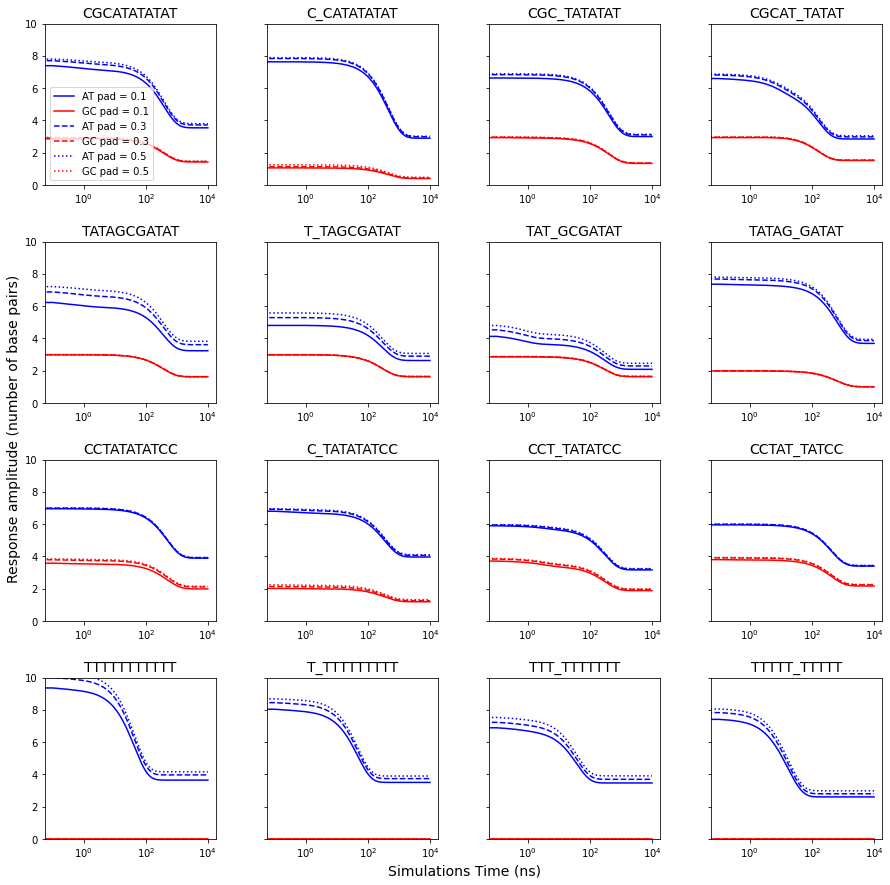

In [6]:
## show all sequences plotted together and save various cutoffs

# load from saved:
seq_list = ['CGCATATATAT', 'TATAGCGATAT', 'CCTATATATCC', 'TTTTTTTTTTT']
fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharey=True)
save_path = './save_relaxations/'
save_txt = False
save_npy = False
save_svg = True
plot_fits = False

complement_dict = {'A':'T', 'T':'A', 'G':'C', 'C':'G'}
bidxs = [0, 2, 4, 6]
lag = 1

maxtime = 1e5
fsize = 14
nits = 3

pad_list = [0.1, 0.3, 0.5]
style_list = ['solid', 'dashed', 'dotted']

for seq, ax_row in zip(seq_list, axes):
    
    save_name = f'./save_outputs/{seq}_lag-{lag}_dict'
    save_dict = pickle.load(open(save_name, 'rb'))

    # load from dict
    base_list = save_dict['base_list'] 
    all_dists = save_dict['all_dists']
    committor_list = save_dict['committor_list']
    dtraj_list = save_dict['dtraj_list']
    msm_list = save_dict['msm_list']
    its_list = save_dict['its_list']
    dtraj_low_list = save_dict['dtraj_low_list']
    
    for bidx, base, msm, base_dists, dtraj, dtraj_low, ax in \
        zip(bidxs, base_list, msm_list, all_dists, dtraj_list, dtraj_low_list, ax_row):
        
        for bp_pad, style in zip(pad_list, style_list):
        
            # score each msm microstate
            AT_cutoff, GC_cutoff= .6+bp_pad, .55+bp_pad
            AT_scores, GC_scores = score_by_bp(msm, dtraj, base_dists, base, AT_cutoff=AT_cutoff, GC_cutoff=GC_cutoff)

            # determine starting distribution from low temp simulations
            p_init = []
            for i in range(msm.nstates):
                micro_sum = np.sum(np.concatenate(dtraj_low)==i)
                p_init.append(micro_sum)
            p_init /= np.sum(np.array(p_init))

            # run relaxation and plots
            times, AT_res = msm.relaxation(p_init, AT_scores, maxtime=maxtime)
            times, GC_res = msm.relaxation(p_init, GC_scores, maxtime=maxtime)

            # fit using summed exponentials
            p0 = [1]*(nits+1)
            AT_popt, _ = curve_fit(exp_sum_fit, times, AT_res, p0=p0, bounds=(0, 1000))
            AT_res_fit = exp_sum_fit(times, *AT_popt)
            GC_popt, _ = curve_fit(exp_sum_fit, times, GC_res, p0=p0, bounds=(0, 1000))
            GC_res_fit = exp_sum_fit(times, *GC_popt)

            # plot AT and GC relaxtions
            ax.plot(times/10, AT_res, label=f'AT pad = {bp_pad}', color='blue', linestyle=style)
            ax.plot(times/10, GC_res, label=f'GC pad = {bp_pad}', color='red', linestyle=style)
            ax.set_xscale('log')

            # show abasic representation in title
            if base=='control': abasic_label= seq
            else:       abasic_label= f'{seq[:bidx-1]}_{seq[bidx:]}'
            ax.set_title(abasic_label, fontsize=fsize)

            print(seq, base)

            # save responses as npys
            if save_npy:
                np.save(f'{save_path}AT_{seq}_{base}_lag-{lag}', AT_res)
                np.save(f'{save_path}GC_{seq}_{base}_lag-{lag}', GC_res)

            # save as text 
            if save_txt:
                with open(f'{save_path}AT_{seq}_{base}_lag-{lag}.txt', 'w') as f:
                    AT_str = [str(x) for x in AT_res]
                    f.writelines('\n'.join(AT_str))
                with open(f'{save_path}GC_{seq}_{base}_lag-{lag}.txt', 'w') as f:
                    GC_str = [str(x) for x in GC_res]
                    f.writelines('\n'.join(GC_str))
                    
            # plot fits
            if plot_fits:
                ax.plot(times, AT_res_fit, linestyle='dashed', label=f'AT fit', color='blue')
                ax.plot(times, GC_res_fit, linestyle='dashed', label=f'GC fit', color='red')

                # plot leading timescales
                label = 'leading implied timescales'
                for ts, AT, GC in zip(msm.timescales(nits), AT_popt[1:], GC_popt[1:]):
                    ax.axvline(ts, linestyle='dashed', color='grey')
                    if AT > 0.001: ax.annotate(np.around(AT, 3), (ts, 7), color='blue')
                    if GC > 0.001: ax.annotate(np.around(GC, 3), (ts, 1), color='red')

spaces = ' '*50
axes[0, 0].legend(loc='lower left')
axes[0, 0].set_ylim(0, 10)
axes[-1, 1].set_xlabel(f'{spaces}Simulations Time (ns)', fontsize=fsize) 
axes[2, 0].set_ylabel(f'{spaces}Response amplitude (number of base pairs)', fontsize=fsize) 
plt.subplots_adjust(hspace=0.35, wspace=0.3)

# save as svg
if save_svg:
    plt.savefig('./figs/all_relaxations_S21.svg', format='svg', bbox_inches='tight', transparent=True, dpi=600)